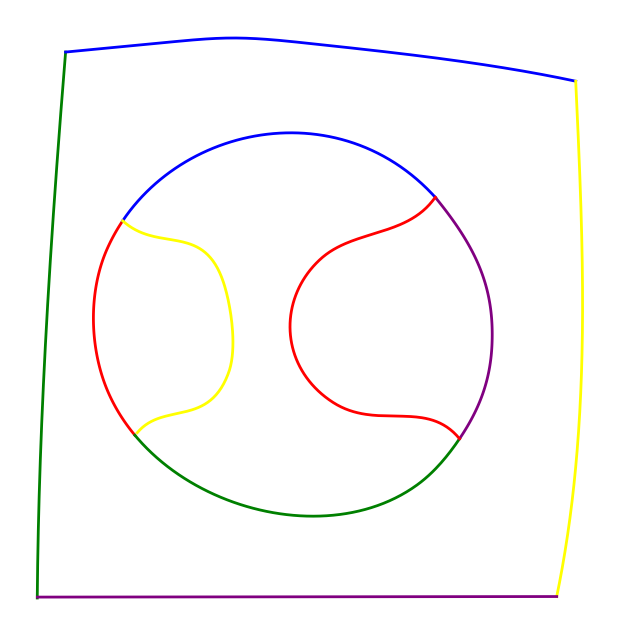

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple']  # Define some colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.axis('off')  # Turn off the axis

# Read and process the CSV file
csv_path = "frag0.csv"
output_data = read_csv_(csv_path)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 8))
plot(output_data, ax)

# Save the plot as a PNG file without extra padding
png_path = "output_shape.png"
plt.savefig(png_path, format='png', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()

# Close the plot to free up memory
plt.close()


<ipython-input-2-229b83e07956>:120: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product / norms)


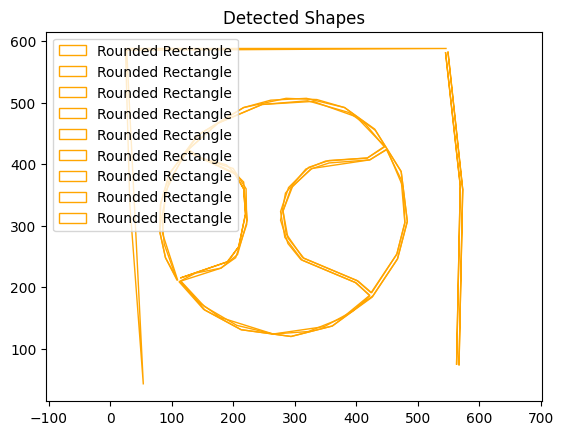

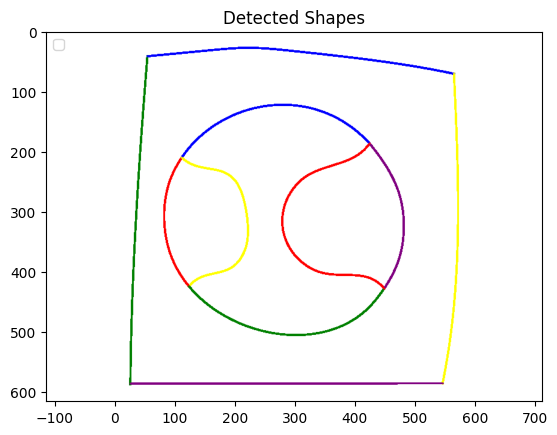

In [2]:
import cv2
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours, approximate_polygon


def image_to_polylines(image_path, epsilon=5):
    """
    Convert an image to a set of polylines.

    Args:
    - image_path (str): Path to the PNG image.
    - epsilon (float): Approximation accuracy for contour approximation.

    Returns:
    - list of polylines: A list where each polyline is a list of (x, y) tuples.
    """
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Detect edges using Canny
    edges = cv2.Canny(img, 50, 150)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    polylines = []
    for contour in contours:
        # Approximate contour to reduce the number of points
        approx = cv2.approxPolyDP(contour, epsilon, True)
        polyline = [(int(point[0][0]), int(point[0][1])) for point in approx]
        polylines.append(polyline)

    return polylines

def is_straight_line(points, tolerance=1e-3):
    """
    Check if a set of points forms a straight line.

    Args:
    - points (list of tuples): List of (x, y) tuples representing the polyline.
    - tolerance (float): Acceptable deviation from a straight line.

    Returns:
    - bool: True if points form a straight line, False otherwise.
    """
    # Convert points to a float array to ensure proper arithmetic operations
    points_array = np.array(points, dtype=float)

    if len(points_array) < 2:
        return False

    direction_vector = points_array[-1] - points_array[0]
    line_magnitude = np.linalg.norm(direction_vector)

    if line_magnitude == 0:
        return False

    direction_vector /= line_magnitude

    deviations = []
    for point in points:
        vector = np.array(point, dtype=float) - points_array[0]
        projection_length = np.dot(vector, direction_vector)
        projection = direction_vector * projection_length
        deviation = np.linalg.norm(vector - projection)
        deviations.append(deviation)

    return all(dev <= tolerance for dev in deviations)

def fit_circle(points):
    # Ensure points are of float type
    points = np.array(points, dtype=float)
    x_m, y_m = np.mean(points, axis=0)

    def calc_radius(c):
        return np.sqrt((points[:, 0] - c[0])**2 + (points[:, 1] - c[1])**2)

    def f(c):
        Ri = calc_radius(c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center, _ = leastsq(f, center_estimate)

    radius = calc_radius(center).mean()

    return (center[0], center[1], radius)

def fit_ellipse(points):
    # Ensure points are of float type
    points = np.array(points, dtype=float)
    x = points[:, 0] - np.mean(points[:, 0])
    y = points[:, 1] - np.mean(points[:, 1])
    U, S, Vt = np.linalg.svd(np.stack((x, y), axis=0))

    center = np.mean(points, axis=0)
    axes = np.sqrt(2) * S / len(points)
    angle = np.arctan2(U[0, 1], U[0, 0])

    return (center[0], center[1], axes[0], axes[1], np.degrees(angle))

def is_rectangle(points, tolerance=1e-2):
    """
    Check if a set of points forms a rectangle.

    Args:
    - points (list of tuples): List of (x, y) tuples representing the polyline.
    - tolerance (float): Acceptable deviation for angles being 90 degrees.

    Returns:
    - bool: True if points form a rectangle, False otherwise.
    """
    if len(points) != 4:
        return False

    def angle_between(v1, v2):
        dot_product = np.dot(v1, v2)
        norms = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.arccos(dot_product / norms)

    vectors = [np.array(points[i], dtype=float) - np.array(points[i - 1], dtype=float) for i in range(len(points))]
    angles = [angle_between(vectors[i], vectors[(i + 1) % len(points)]) for i in range(len(vectors))]

    # Check if all angles are close to 90 degrees (π/2 radians)
    return all(abs(angle - np.pi / 2) <= tolerance for angle in angles)

def is_rounded_rectangle(points, radius_threshold=0.2):
    """
    Check if a set of points forms a rounded rectangle.

    Args:
    - points (list of tuples): List of (x, y) tuples representing the polyline.
    - radius_threshold (float): Threshold to determine curvature at corners.

    Returns:
    - bool: True if points form a rounded rectangle, False otherwise.
    """
    corners = []
    for i in range(1, len(points) - 1):
        v1 = np.array(points[i], dtype=float) - np.array(points[i - 1], dtype=float)
        v2 = np.array(points[i + 1], dtype=float) - np.array(points[i], dtype=float)
        angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
        angle = (angle + np.pi) % (2 * np.pi) - np.pi

        if abs(angle) < radius_threshold:
            corners.append(points[i])

    # Rounded rectangle should have fewer than 4 sharp corners
    return len(corners) < 4

def is_regular_polygon(points, tolerance=1e-2):
    """
    Check if a set of points forms a regular polygon.

    Args:
    - points (list of tuples): List of (x, y) tuples representing the polyline.
    - tolerance (float): Acceptable deviation for equal sides and angles.

    Returns:
    - bool: True if points form a regular polygon, False otherwise.
    """
    # Ensure points are of float type
    points = np.array(points, dtype=float)
    side_lengths = [np.linalg.norm(points[i] - points[i - 1]) for i in range(len(points))]

    vectors = [points[i] - points[i - 1] for i in range(len(points))]
    angles = [np.arctan2(vectors[i][1], vectors[i][0]) - np.arctan2(vectors[(i + 1) % len(points)][1], vectors[(i + 1) % len(points)][0]) for i in range(len(vectors))]

    side_check = all(abs(side_lengths[i] - side_lengths[0]) <= tolerance for i in range(len(side_lengths)))
    angle_check = all(abs(angles[i] - angles[0]) <= tolerance for i in range(len(angles)))

    return side_check and angle_check

def is_star_shape(points, tolerance=1e-2):
    """
    Check if a set of points forms a star shape.

    Args:
    - points (list of tuples): List of (x, y) tuples representing the polyline.
    - tolerance (float): Acceptable deviation from radial symmetry.

    Returns:
    - bool: True if points form a star shape, False otherwise.
    """
    # Ensure points are of float type
    points = np.array(points, dtype=float)
    center = np.mean(points, axis=0)
    vectors = [point - center for point in points]

    angles = [np.arctan2(v[1], v[0]) for v in vectors]
    angles_sorted_indices = np.argsort(angles)
    vectors_sorted = [vectors[i] for i in angles_sorted_indices]

    distances = [np.linalg.norm(v) for v in vectors_sorted]
    distance_diffs = [abs(distances[i] - distances[i - 1]) for i in range(1, len(distances))]

    alternating_diffs = distance_diffs[::2] + distance_diffs[1::2]
    is_symmetric = all(abs(diff - alternating_diffs[0]) <= tolerance for diff in alternating_diffs)

    return is_symmetric

def detect_shapes_from_image(image_path):
    """
    Detect shapes from a PNG image and classify them.

    Args:
    - image_path (str): Path to the PNG image.

    Returns:
    - list of dicts: Detected shapes with their properties.
    """
    polylines = image_to_polylines(image_path)
    detected_shapes = []

    for polyline in polylines:
        if is_straight_line(polyline):
            detected_shapes.append({'type': 'straight line', 'points': polyline})
        elif len(polyline) >= 4:
            if is_rectangle(polyline):
                detected_shapes.append({'type': 'rectangle', 'points': polyline})
            elif is_rounded_rectangle(polyline):
                detected_shapes.append({'type': 'rounded rectangle', 'points': polyline})
            elif is_regular_polygon(polyline):
                detected_shapes.append({'type': 'regular polygon', 'points': polyline})
            elif is_star_shape(polyline):
                detected_shapes.append({'type': 'star shape', 'points': polyline})
        elif len(polyline) >= 3:
            try:
                center, radius = fit_circle(polyline)
                detected_shapes.append({'type': 'circle', 'center': center, 'radius': radius, 'points': polyline})
            except:
                pass
            try:
                cx, cy, major, minor, angle = fit_ellipse(polyline)
                detected_shapes.append({'type': 'ellipse', 'center': (cx, cy), 'axes': (major, minor), 'angle': angle, 'points': polyline})
            except:
                pass

    return detected_shapes

def display_shapes(shapes):
    """
    Display detected shapes using matplotlib.

    Args:
    - shapes (list of dicts): Detected shapes with their properties.
    """
    fig, ax = plt.subplots()

    for shape in shapes:
        if shape['type'] == 'straight line':
            x, y = zip(*shape['points'])
            ax.plot(x, y, label='Straight Line', color='blue')
        elif shape['type'] == 'circle':
            circle = patches.Circle(shape['center'], shape['radius'], fill=False, edgecolor='green', label='Circle')
            ax.add_patch(circle)
        elif shape['type'] == 'ellipse':
            ellipse = patches.Ellipse(shape['center'], shape['axes'][0] * 2, shape['axes'][1] * 2, angle=shape['angle'], fill=False, edgecolor='red', label='Ellipse')
            ax.add_patch(ellipse)
        elif shape['type'] == 'rectangle':
            poly = np.array(shape['points'])
            rectangle = patches.Polygon(poly, closed=True, fill=False, edgecolor='purple', label='Rectangle')
            ax.add_patch(rectangle)
        elif shape['type'] == 'rounded rectangle':
            poly = np.array(shape['points'])
            rounded_rectangle = patches.Polygon(poly, closed=True, fill=False, edgecolor='orange', label='Rounded Rectangle')
            ax.add_patch(rounded_rectangle)
        elif shape['type'] == 'regular polygon':
            poly = np.array(shape['points'])
            regular_polygon = patches.Polygon(poly, closed=True, fill=False, edgecolor='brown', label='Regular Polygon')
            ax.add_patch(regular_polygon)
        elif shape['type'] == 'star shape':
            poly = np.array(shape['points'])
            star_shape = patches.Polygon(poly, closed=True, fill=False, edgecolor='black', label='Star Shape')
            ax.add_patch(star_shape)

    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.title('Detected Shapes')
    plt.show()

# Example usage:
image_path = '/content/output_shape.png'  # Replace with your image path
detected_shapes = detect_shapes_from_image(image_path)
display_shapes(detected_shapes)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def preprocess_image(image_path):
    """
    Preprocess the image to improve edge detection.

    Args:
    - image_path (str): Path to the PNG image.

    Returns:
    - preprocessed_image: Binarized image with edges detected.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Binarize the image
    _, binary_image = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    return binary_image

def detect_circles_hough(image):
    """
    Detect circles using Hough Circle Transform.

    Args:
    - image (numpy array): Binary image with edges.

    Returns:
    - list of tuples: Detected circles (center_x, center_y, radius).
    """
    circles = cv2.HoughCircles(
        image,
        cv2.HOUGH_GRADIENT,
        dp=1.0,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=100
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        return [(x, y, r) for x, y, r in circles]
    return []

def is_star_shape(contour, num_points=5, tolerance=0.2):
    """
    Detect if the given contour is a star shape.

    Args:
    - contour (numpy array): Contour points.
    - num_points (int): Expected number of star points.
    - tolerance (float): Tolerance for detecting star shape.

    Returns:
    - bool: True if the contour is a star shape, otherwise False.
    """
    hull = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, hull)

    if defects is None or len(defects) < num_points:
        return False

    # Count the number of convexity defects (inward points)
    inward_points = 0
    for i in range(defects.shape[0]):
        start_idx, end_idx, farthest_idx, distance = defects[i, 0]
        if distance > tolerance * cv2.arcLength(contour, True):
            inward_points += 1

    return inward_points == num_points

def detect_shapes_from_image(image_path):
    """
    Detect shapes from a PNG image and classify them.

    Args:
    - image_path (str): Path to the PNG image.

    Returns:
    - list of dicts: Detected shapes with their properties.
    """
    binary_image = preprocess_image(image_path)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []

    # Detect circles
    circles = detect_circles_hough(binary_image)
    for (x, y, r) in circles:
        detected_shapes.append({'type': 'circle', 'center': (x, y), 'radius': r})

    # Detect star shapes
    for contour in contours:
        if len(contour) >= 5:  # Minimum number of points for a star
            if is_star_shape(contour):
                polyline = [(int(point[0][0]), int(point[0][1])) for point in contour]
                detected_shapes.append({'type': 'star', 'points': polyline})

    return detected_shapes

def display_shapes(shapes, image_path):
    """
    Display detected shapes using matplotlib.

    Args:
    - shapes (list of dicts): Detected shapes with their properties.
    - image_path (str): Path to the PNG image.
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots()
    ax.imshow(img_rgb)

    for shape in shapes:
        if shape['type'] == 'circle':
            circle = patches.Circle(shape['center'], shape['radius'], fill=False, edgecolor='green', label='Circle')
            ax.add_patch(circle)
        elif shape['type'] == 'star':
            poly = np.array(shape['points'])
            star_shape = patches.Polygon(poly, closed=True, fill=False, edgecolor='blue', label='Star')
            ax.add_patch(star_shape)

    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.title('Detected Shapes')
    plt.show()

# Example usage:
image_path = '/content/output_shape.png'  # Replace with your image path
detected_shapes = detect_shapes_from_image(image_path)
display_shapes(detected_shapes, image_path)



Error detecting star: index 1 is out of bounds for axis 0 with size 1
Error detecting star: index 1 is out of bounds for axis 0 with size 1
Error detecting star: index 1 is out of bounds for axis 0 with size 1


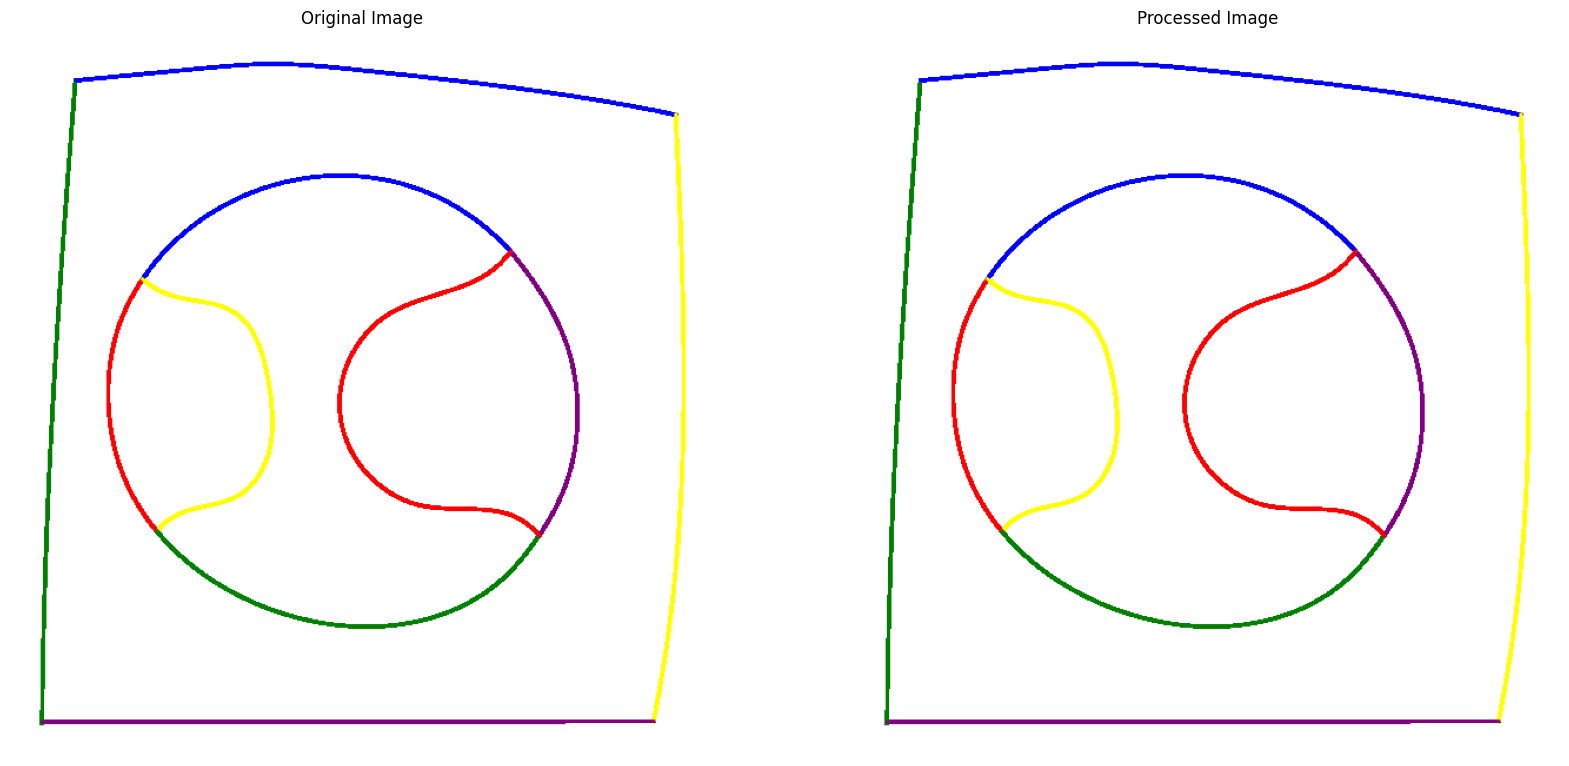

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import leastsq

def preprocess_image(image_path):
    """
    Preprocess the image to improve edge detection.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at path {image_path}")
    _, binary_image = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    return binary_image

def detect_shapes_from_image(image_path):
    """
    Detect shapes from a PNG image and classify them.
    """
    binary_image = preprocess_image(image_path)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []
    for contour in contours:
        if len(contour) >= 3:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            if len(approx) == 4:
                if is_rectangle(approx):
                    detected_shapes.append({'type': 'rectangle', 'points': approx.reshape(-1, 2)})
                elif is_square(approx):
                    detected_shapes.append({'type': 'square', 'points': approx.reshape(-1, 2)})
            elif len(approx) >= 5:
                try:
                    if is_star(approx):
                        detected_shapes.append({'type': 'star', 'points': approx.reshape(-1, 2)})
                except Exception as e:
                    print(f"Error detecting star: {e}")
            elif len(approx) >= 3:
                try:
                    center, radius = fit_circle(approx.reshape(-1, 2))
                    detected_shapes.append({'type': 'circle', 'center': center, 'radius': radius, 'points': approx.reshape(-1, 2)})
                except Exception as e:
                    print(f"Error fitting circle: {e}")

    return detected_shapes

def is_rectangle(points, tolerance=1e-2):
    """
    Check if a set of points forms a rectangle.
    """
    if len(points) != 4:
        return False

    def angle_between(v1, v2):
        dot_product = np.dot(v1, v2)
        norms = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.arccos(dot_product / norms)

    vectors = [np.array(points[i]) - np.array(points[i - 1]) for i in range(len(points))]
    angles = [angle_between(vectors[i], vectors[(i + 1) % len(points)]) for i in range(len(vectors))]

    return all(abs(angle - np.pi / 2) <= tolerance for angle in angles)

def is_square(points):
    """
    Check if a set of points forms a square.
    """
    if len(points) != 4:
        return False

    def distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    side_lengths = [distance(points[i], points[(i + 1) % 4]) for i in range(4)]
    diagonals = [distance(points[i], points[(i + 2) % 4]) for i in range(2)]

    side_check = all(abs(side_lengths[i] - side_lengths[0]) <= 1e-2 for i in range(4))
    diagonal_check = all(abs(diagonals[i] - diagonals[0]) <= 1e-2 for i in range(2))

    return side_check and diagonal_check

def fit_circle(points):
    """
    Fit a circle to a set of points.
    """
    points = np.array(points, dtype=float)
    x_m, y_m = np.mean(points, axis=0)

    def calc_radius(c):
        return np.sqrt((points[:, 0] - c[0])**2 + (points[:, 1] - c[1])**2)

    def f(c):
        Ri = calc_radius(c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center, _ = leastsq(f, center_estimate)

    radius = calc_radius(center).mean()
    return (center[0], center[1], radius)

def is_star(points, tolerance=1e-2):
    """
    Check if a set of points forms a star shape.
    """
    if len(points) < 5:
        raise ValueError("Not enough points to detect a star")

    points = np.array(points, dtype=float)
    center = np.mean(points, axis=0)
    vectors = [point - center for point in points]

    if len(vectors) < 5:
        raise ValueError("Not enough vectors to detect a star")

    angles = [np.arctan2(v[1], v[0]) for v in vectors]
    angles_sorted_indices = np.argsort(angles)
    vectors_sorted = [vectors[i] for i in angles_sorted_indices]

    distances = [np.linalg.norm(v) for v in vectors_sorted]
    distance_diffs = [abs(distances[i] - distances[i - 1]) for i in range(1, len(distances))]

    alternating_diffs = distance_diffs[::2] + distance_diffs[1::2]
    is_symmetric = all(abs(diff - alternating_diffs[0]) <= tolerance for diff in alternating_diffs)

    return is_symmetric

def plot_detected_shapes(image_path, detected_shapes):
    """
    Plot the original and processed images side by side.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Plot original image
    ax[0].imshow(img_rgb)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Plot processed image with detected shapes
    img_processed = img.copy()
    for shape in detected_shapes:
        if shape['type'] == 'circle':
            cv2.circle(img_processed, (int(shape['center'][0]), int(shape['center'][1])), int(shape['radius']), (0, 255, 0), 2)
        elif shape['type'] in ['rectangle', 'square']:
            cv2.polylines(img_processed, [np.int32(shape['points'])], isClosed=True, color=(255, 0, 0), thickness=2)
        elif shape['type'] == 'star':
            # Approximate star shape with polyline
            cv2.polylines(img_processed, [np.int32(shape['points'])], isClosed=True, color=(0, 0, 255), thickness=2)

    ax[1].imshow(cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Processed Image')
    ax[1].axis('off')

    plt.show()

# Example usage:
image_path = '/content/output_shape.png'  # Replace with your image path
try:
    detected_shapes = detect_shapes_from_image(image_path)
    plot_detected_shapes(image_path, detected_shapes)
except Exception as e:
    print(f"Error: {e}")


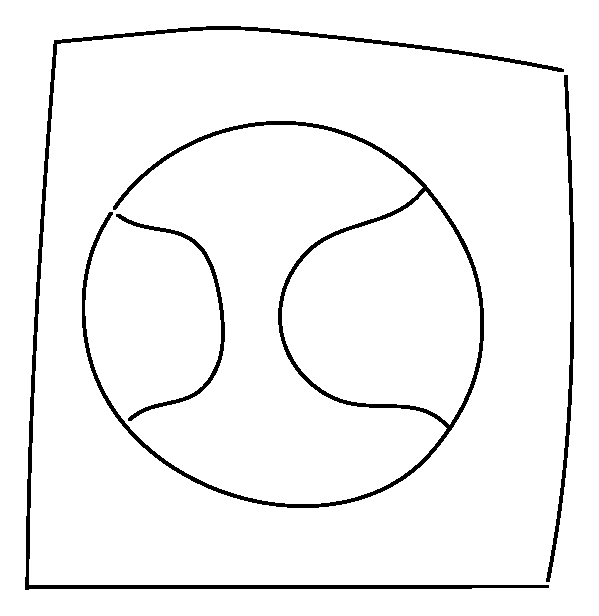

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread('/content/output_shape.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

# Apply morphological operations to enhance lines
kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)

# Save the processed image
cv2.imwrite('shapes_processed.png', eroded_image)

# Display the processed image
cv2_imshow(eroded_image)


# CODE FOR **REGULARIZATION**

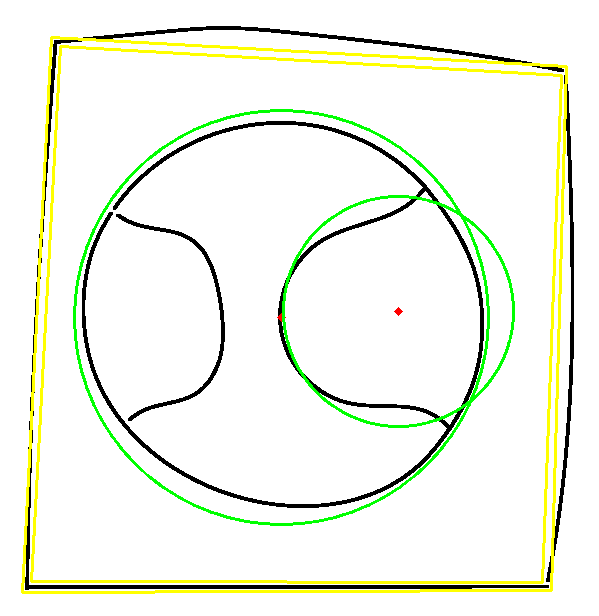

In [7]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread('shapes_processed.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Apply morphological operations to connect broken lines
kernel = np.ones((7, 7), np.uint8)  # Larger kernel to connect more
processed = cv2.dilate(binary, kernel, iterations=2)  # Increased iterations
processed = cv2.erode(processed, kernel, iterations=1)

# Find contours
contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def fit_approximate_shape(contour):
    # Approximate the contour to a polygon with a larger epsilon value
    epsilon = 0.05 * cv2.arcLength(contour, True)  # Larger epsilon
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def is_circle(contour):
    # Fit a circle to the contour and check its roundness
    if len(contour) >= 5:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        # Reduce accuracy by broadening the circularity range
        return 0.8 < circularity < 1.1
    return False

def is_square(approx):
    # Check if the approximated polygon is a square
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        # A square has an aspect ratio close to 1
        return 0.9 <= aspect_ratio <= 1.1
    return False

# Draw detected shapes on the image
for contour in contours:
    if is_circle(contour):
        # If detected as a circle, draw the circle and skip other checks
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, (0, 255, 0), 2)  # Draw the circle outline
        cv2.circle(image, center, 2, (0, 0, 255), 3)      # Draw the center of the circle
    else:
        # If not a circle, proceed to check for other shapes
        approx = fit_approximate_shape(contour)
        if len(approx) == 3:
            # Triangle
            cv2.polylines(image, [approx], True, (255, 0, 0), 2)
        elif len(approx) == 4:
            # Square or Rectangle
            if is_square(approx):
                cv2.polylines(image, [approx], True, (0, 255, 255), 2)  # Draw square in cyan
            else:
                cv2.polylines(image, [approx], True, (0, 0, 255), 2)    # Draw rectangle in red

# Save and display the result
cv2.imwrite('shapes_detected.png', image)
cv2_imshow(image)


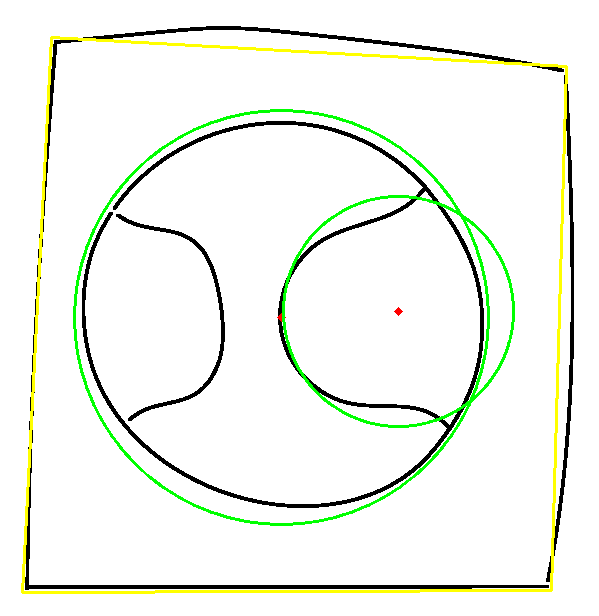

In [16]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread('shapes_processed.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Apply morphological operations to connect broken lines
kernel = np.ones((7, 7), np.uint8)
processed = cv2.dilate(binary, kernel, iterations=2)
processed = cv2.erode(processed, kernel, iterations=1)

# Find contours
contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def fit_approximate_shape(contour):
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def is_circle(contour):
    if len(contour) >= 5:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        return 0.8 < circularity < 1.1
    return False

def is_square(approx):
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        return 0.9 <= aspect_ratio <= 1.1
    return False

def calculate_angle(pt1, pt2):
    """Calculate the angle of the line between two points relative to the horizontal."""
    dx = pt2[0] - pt1[0]
    dy = pt2[1] - pt1[1]
    return np.degrees(np.arctan2(dy, dx))

def shapes_are_parallel(approx1, approx2):
    """Check if two shapes have similar angles, indicating they are parallel."""
    if len(approx1) != len(approx2):
        return False

    angles1 = [calculate_angle(approx1[i][0], approx1[(i + 1) % len(approx1)][0]) for i in range(len(approx1))]
    angles2 = [calculate_angle(approx2[i][0], approx2[(i + 1) % len(approx2)][0]) for i in range(len(approx2))]

    for angle1, angle2 in zip(angles1, angles2):
        if abs(angle1 - angle2) > 10:  # 10 degrees tolerance
            return False
    return True

def contours_are_close(cnt1, cnt2, threshold=10):
    """Check if two contours are close to each other."""
    rect1 = cv2.boundingRect(cnt1)
    rect2 = cv2.boundingRect(cnt2)

    if abs(rect1[0] - rect2[0]) < threshold and abs(rect1[1] - rect2[1]) < threshold:
        return True

    return False

detected_shapes = []

for contour in contours:
    if is_circle(contour):
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, (0, 255, 0), 2)
        cv2.circle(image, center, 2, (0, 0, 255), 3)
    else:
        approx = fit_approximate_shape(contour)
        should_draw = True

        for shape in detected_shapes:
            if shapes_are_parallel(shape, approx) or contours_are_close(shape, approx):
                should_draw = False
                break

        if should_draw:
            detected_shapes.append(approx)
            if len(approx) == 3:
                cv2.polylines(image, [approx], True, (255, 0, 0), 2)
            elif len(approx) == 4:
                if is_square(approx):
                    cv2.polylines(image, [approx], True, (0, 255, 255), 2)
                else:
                    cv2.polylines(image, [approx], True, (0, 0, 255), 2)

# Save and display the result
cv2.imwrite('shapes_detected.png', image)
cv2_imshow(image)


# CODE FOR **SYMMERTY**

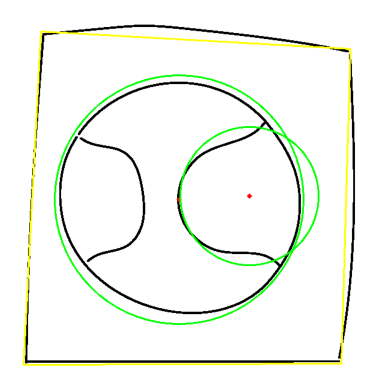

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def draw_dotted_line(img, pt1, pt2, color, thickness=1, gap=5):
    """Draws a dotted line between two points on an image."""
    dist = np.linalg.norm(np.array(pt1) - np.array(pt2))
    pts = [
        (
            int(pt1[0] + (pt2[0] - pt1[0]) * i / dist),
            int(pt1[1] + (pt2[1] - pt1[1]) * i / dist)
        )
        for i in np.arange(0, dist, gap)
    ]
    for p in pts:
        cv2.circle(img, p, thickness, color, -1)

# Load the image
image = cv2.imread('shapes_detected.png')
height, width = image.shape[:2]

# Convert to grayscale for symmetry detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding the image to get binary shapes
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours of the shapes
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the line of symmetry within each detected shape
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Ensure the width and height are even
    if w % 2 != 0:
        w -= 1
    if h % 2 != 0:
        h -= 1

    # Vertical symmetry within the shape
    left_half = gray[y:y+h, x:x+w//2]
    right_half = cv2.flip(gray[y:y+h, x+w//2:x+w], 1)
    vertical_symmetry = cv2.absdiff(left_half, right_half)
    vertical_score = np.sum(vertical_symmetry)

    # Horizontal symmetry within the shape
    top_half = gray[y:y+h//2, x:x+w]
    bottom_half = cv2.flip(gray[y+h//2:y+h, x:x+w], 0)
    horizontal_symmetry = cv2.absdiff(top_half, bottom_half)
    horizontal_score = np.sum(horizontal_symmetry)

    # Draw dotted lines for detected symmetry within the shape
    if vertical_score < 10000:  # Threshold for symmetry detection
        draw_dotted_line(image, (x+w//2, y), (x+w//2, y+h), (0, 255, 0), thickness=2)

    if horizontal_score < 10000:  # Threshold for symmetry detection
        draw_dotted_line(image, (x, y+h//2), (x+w, y+h//2), (255, 0, 0), thickness=2)

# Save and display the result
cv2.imwrite('symmetry_detected.png', image)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
